In [1]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
import sqlite3

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


C:\Users\Simo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Preprocessing and feature engineering

In [89]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()

In [85]:
songs.shape

(12867139, 4)

In [90]:
songs.columns = ['user_id', 'artistname','trackname','playlistname']
songs[songs['artistname'] == 'Pink Floyd'].head()

,user_id,artistname,trackname,playlistname
896,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Sorrow - Live,Starred
1057,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Comfortably Numb,Work playlist
1058,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Comfortably Numb - Live,Work playlist
1098,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Echoes - 2011 Remastered Version,Work playlist
1099,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Eclipse - 2011 Remastered Version,Work playlist


In [91]:
def clean_tracks(trackname):
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #lowercase for ease of querying
    trackname = trackname.lower()
     
    #radio_edit = ['[radio edit]', '(radio edit)', 'radio edit']
    #explicit = ['[explicit]', '(explicit)']
    #live = ['live']
    #remaster = ['remaster','remastered']
    #version = ['version']
        
    return trackname

In [92]:
songs['trackname'] = songs['trackname'].copy().apply(clean_tracks)

In [93]:
songs[songs['artistname'] == 'Pink Floyd'].head()

,user_id,artistname,trackname,playlistname
896,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,sorrow,Starred
1057,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,comfortably numb,Work playlist
1058,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,comfortably numb,Work playlist
1098,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,echoes,Work playlist
1099,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,eclipse,Work playlist


In [94]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between covers
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]


In [95]:
songs.head()

,user_id,artistname,trackname,playlistname,trackartist,userplaylist
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(the angels wanna wear my) red shoes,HARD ROCK 2010,Elvis Costello - (the angels wanna wear my) re...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(what's so funny 'bout) peace, love and unders...",HARD ROCK 2010,Elvis Costello & The Attractions - (what's so ...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 years too late,HARD ROCK 2010,Tiffany Page - 7 years too late,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,accidents will happen,HARD ROCK 2010,Elvis Costello & The Attractions - accidents w...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,alison,HARD ROCK 2010,Elvis Costello - alison,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010


In [97]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [98]:
playlists.head()

,trackartist
userplaylist,
00055176fea33f6e027cd3302289378b - favs,"[Jannik Brunke - 18, Green Day - 21 guns, Shaw..."
0007f3dd09c91198371454c608d47f22 - Fav songs,[Bryan Adams - (everything i do) i do it for y...
000b0f32b5739f052b9d40fcc5c41079 - Contacta,"[Veronica Maggio - bas gillar hörn, Titiyo - b..."
000b0f32b5739f052b9d40fcc5c41079 - Gospel,"[The Worship Crew - brighter day, Oslo Gospel ..."
000b0f32b5739f052b9d40fcc5c41079 - Starred,"[Java Gospel - a blessed christmas eve, Java G..."


In [99]:
#playlists[playlists.index.str.match('0007f3dd09c91198371454c608d47f22 - Fav songs')]
playlists.shape

(188437, 1)

In [104]:
def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [101]:
documents = to_document(playlists)

In [105]:
len(documents)

188437

## Training Word2vec-music recommender

In [106]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [111]:
index = np.random.choice(range(len(documents)), 180000, replace=False)

In [112]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
train = np.array(documents)[index[:144000]].tolist()
test = np.array(documents)[index[144000:]].tolist()

In [ ]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [115]:
#initial parameteres from https://arxiv.org/abs/1804.04212
window_size=7
it=20 #increasing this leads to returning words with wrong similarity#
sample=0.001 
power_alpha=0.025

size_embedding=50
neg_sample=5
workers=10
min_count=2



model = gensim.models.Word2Vec(train, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(train,total_examples=len(train), epochs=model.iter)

2019-02-11 12:13:47,553 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-02-11 12:13:47,554 : INFO : collecting all words and their counts
2019-02-11 12:13:47,555 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-11 12:13:47,913 : INFO : PROGRESS: at sentence #10000, processed 691700 words, keeping 380047 word types
2019-02-11 12:13:48,255 : INFO : PROGRESS: at sentence #20000, processed 1352213 words, keeping 618443 word types
2019-02-11 12:13:48,669 : INFO : PROGRESS: at sentence #30000, processed 2003468 words, keeping 811599 word types
2019-02-11 12:13:49,085 : INFO : PROGRESS: at sentence #40000, processed 2699852 words, keeping 1002577 word types
2019-02-11 12:13:49,455 : INFO : PROGRESS: at sentence #50000, processed 3353706 words, keeping 1152898 word types
2019-02-11 12:13:49,867 : INFO : PROGRESS: at sentence #60000, processed 4052324 words, keeping 1296296 word types
2019-02-11 12:13:50,401 : INFO : PROG

2019-02-11 12:14:56,097 : INFO : EPOCH 2 - PROGRESS: at 82.66% examples, 375633 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:14:57,131 : INFO : EPOCH 2 - PROGRESS: at 87.57% examples, 375583 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:14:58,180 : INFO : EPOCH 2 - PROGRESS: at 92.22% examples, 375430 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:14:59,196 : INFO : EPOCH 2 - PROGRESS: at 96.72% examples, 375074 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:14:59,783 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:14:59,789 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:14:59,817 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:14:59,836 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:14:59,843 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:14:59,874 : INFO : worker thread finished; awaiting finish of 4 more thread

2019-02-11 12:15:44,111 : INFO : EPOCH - 4 : training on 9586658 raw words (8315401 effective words) took 22.0s, 377720 effective words/s
2019-02-11 12:15:45,132 : INFO : EPOCH 5 - PROGRESS: at 3.94% examples, 329814 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:15:46,141 : INFO : EPOCH 5 - PROGRESS: at 8.94% examples, 372248 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:15:47,158 : INFO : EPOCH 5 - PROGRESS: at 13.69% examples, 378364 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:15:48,170 : INFO : EPOCH 5 - PROGRESS: at 18.46% examples, 379341 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:15:49,174 : INFO : EPOCH 5 - PROGRESS: at 22.96% examples, 378871 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:15:50,189 : INFO : EPOCH 5 - PROGRESS: at 27.38% examples, 378158 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:15:51,189 : INFO : EPOCH 5 - PROGRESS: at 32.22% examples, 380877 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:15:52,203 : INFO : EPOCH 5 - PROGRESS: at 36.77% exa

2019-02-11 12:16:40,134 : INFO : EPOCH 7 - PROGRESS: at 55.46% examples, 382580 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:16:41,182 : INFO : EPOCH 7 - PROGRESS: at 60.70% examples, 383040 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:16:42,240 : INFO : EPOCH 7 - PROGRESS: at 65.84% examples, 382968 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:16:43,249 : INFO : EPOCH 7 - PROGRESS: at 70.80% examples, 383380 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:16:44,266 : INFO : EPOCH 7 - PROGRESS: at 75.15% examples, 382815 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:16:45,315 : INFO : EPOCH 7 - PROGRESS: at 80.03% examples, 383561 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:16:46,326 : INFO : EPOCH 7 - PROGRESS: at 84.97% examples, 383422 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:16:47,349 : INFO : EPOCH 7 - PROGRESS: at 89.72% examples, 383110 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:16:48,375 : INFO : EPOCH 7 - PROGRESS: at 94.33% examples, 383231 words/s,

2019-02-11 12:17:33,856 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:17:33,880 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:17:33,886 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:17:33,913 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:17:33,943 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:17:33,944 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:17:33,985 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:17:33,986 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:17:33,987 : INFO : EPOCH - 9 : training on 9586658 raw words (8315401 effective words) took 22.3s, 372407 effective words/s
2019-02-11 12:17:35,014 : INFO : EPOCH 10 - PROGRESS: at 4.16% examples, 352475 words/s, in_qsize 17, out_qsize 2
2019-02-11 12:17:36,

2019-02-11 12:18:22,573 : INFO : EPOCH 12 - PROGRESS: at 29.38% examples, 393901 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:18:23,613 : INFO : EPOCH 12 - PROGRESS: at 34.40% examples, 394088 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:24,624 : INFO : EPOCH 12 - PROGRESS: at 38.99% examples, 394328 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:25,691 : INFO : EPOCH 12 - PROGRESS: at 43.78% examples, 395065 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:26,705 : INFO : EPOCH 12 - PROGRESS: at 48.98% examples, 397198 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:27,724 : INFO : EPOCH 12 - PROGRESS: at 53.71% examples, 396091 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:28,764 : INFO : EPOCH 12 - PROGRESS: at 59.04% examples, 396773 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:18:29,769 : INFO : EPOCH 12 - PROGRESS: at 64.13% examples, 396966 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:18:30,770 : INFO : EPOCH 12 - PROGRESS: at 68.99% examples, 395708

2019-02-11 12:19:18,297 : INFO : EPOCH 14 - PROGRESS: at 84.36% examples, 380666 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:19:19,318 : INFO : EPOCH 14 - PROGRESS: at 89.43% examples, 381440 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:19:20,355 : INFO : EPOCH 14 - PROGRESS: at 94.05% examples, 381499 words/s, in_qsize 17, out_qsize 2
2019-02-11 12:19:21,406 : INFO : EPOCH 14 - PROGRESS: at 98.35% examples, 381287 words/s, in_qsize 15, out_qsize 0
2019-02-11 12:19:21,504 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:19:21,506 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:19:21,544 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:19:21,568 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:19:21,590 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:19:21,615 : INFO : worker thread finished; awaiting finish of 4 more th

2019-02-11 12:20:06,239 : INFO : EPOCH 17 - PROGRESS: at 3.94% examples, 333914 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:20:07,286 : INFO : EPOCH 17 - PROGRESS: at 9.02% examples, 371308 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:20:08,295 : INFO : EPOCH 17 - PROGRESS: at 13.90% examples, 383034 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:20:09,333 : INFO : EPOCH 17 - PROGRESS: at 18.86% examples, 383565 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:20:10,339 : INFO : EPOCH 17 - PROGRESS: at 23.64% examples, 386221 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:20:11,372 : INFO : EPOCH 17 - PROGRESS: at 28.33% examples, 387635 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:20:12,393 : INFO : EPOCH 17 - PROGRESS: at 33.00% examples, 385735 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:20:13,401 : INFO : EPOCH 17 - PROGRESS: at 37.85% examples, 388241 words/s, in_qsize 20, out_qsize 2
2019-02-11 12:20:14,402 : INFO : EPOCH 17 - PROGRESS: at 42.54% examples, 390721 w

2019-02-11 12:21:02,683 : INFO : EPOCH 19 - PROGRESS: at 73.92% examples, 399625 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:21:03,711 : INFO : EPOCH 19 - PROGRESS: at 78.78% examples, 399464 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:21:04,723 : INFO : EPOCH 19 - PROGRESS: at 83.99% examples, 400087 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:21:05,747 : INFO : EPOCH 19 - PROGRESS: at 89.23% examples, 399946 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:21:06,787 : INFO : EPOCH 19 - PROGRESS: at 93.95% examples, 399706 words/s, in_qsize 16, out_qsize 3
2019-02-11 12:21:07,801 : INFO : EPOCH 19 - PROGRESS: at 98.35% examples, 399735 words/s, in_qsize 15, out_qsize 0
2019-02-11 12:21:07,924 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:21:07,948 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:21:07,950 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:21:07,977 : INFO : work

2019-02-11 12:21:50,132 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:21:50,133 : INFO : EPOCH - 21 : training on 9586658 raw words (8315401 effective words) took 21.1s, 394097 effective words/s
2019-02-11 12:21:51,143 : INFO : EPOCH 22 - PROGRESS: at 3.94% examples, 333207 words/s, in_qsize 18, out_qsize 2
2019-02-11 12:21:52,144 : INFO : EPOCH 22 - PROGRESS: at 9.02% examples, 379485 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:21:53,182 : INFO : EPOCH 22 - PROGRESS: at 13.82% examples, 383872 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:21:54,185 : INFO : EPOCH 22 - PROGRESS: at 19.05% examples, 391334 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:21:55,207 : INFO : EPOCH 22 - PROGRESS: at 23.70% examples, 390257 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:21:56,227 : INFO : EPOCH 22 - PROGRESS: at 28.43% examples, 391571 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:21:57,227 : INFO : EPOCH 22 - PROGRESS: at 33.33% examples, 394614 w

2019-02-11 12:22:45,443 : INFO : EPOCH 24 - PROGRESS: at 62.24% examples, 393826 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:22:46,451 : INFO : EPOCH 24 - PROGRESS: at 67.46% examples, 394184 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:22:47,457 : INFO : EPOCH 24 - PROGRESS: at 72.42% examples, 394776 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:22:48,503 : INFO : EPOCH 24 - PROGRESS: at 77.17% examples, 394770 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:22:49,505 : INFO : EPOCH 24 - PROGRESS: at 82.01% examples, 395126 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:22:50,532 : INFO : EPOCH 24 - PROGRESS: at 87.09% examples, 395097 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:22:51,561 : INFO : EPOCH 24 - PROGRESS: at 92.12% examples, 395660 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:22:52,586 : INFO : EPOCH 24 - PROGRESS: at 97.05% examples, 396030 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:22:53,070 : INFO : worker thread finished; awaiting finish of 9 mo

2019-02-11 12:23:34,802 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:23:34,828 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:23:34,839 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:23:34,839 : INFO : EPOCH - 26 : training on 9586658 raw words (8315401 effective words) took 20.8s, 399894 effective words/s
2019-02-11 12:23:35,859 : INFO : EPOCH 27 - PROGRESS: at 4.09% examples, 354520 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:23:36,886 : INFO : EPOCH 27 - PROGRESS: at 9.20% examples, 381562 words/s, in_qsize 20, out_qsize 2
2019-02-11 12:23:37,892 : INFO : EPOCH 27 - PROGRESS: at 14.06% examples, 390371 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:23:38,901 : INFO : EPOCH 27 - PROGRESS: at 19.16% examples, 392535 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:23:39,930 : INFO : EPOCH 27 - PROGRESS: at 23.98% examples, 392691 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:2

2019-02-11 12:24:27,915 : INFO : EPOCH 29 - PROGRESS: at 52.44% examples, 397271 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:28,927 : INFO : EPOCH 29 - PROGRESS: at 57.12% examples, 395693 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:29,942 : INFO : EPOCH 29 - PROGRESS: at 61.98% examples, 394253 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:30,951 : INFO : EPOCH 29 - PROGRESS: at 67.33% examples, 395182 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:31,974 : INFO : EPOCH 29 - PROGRESS: at 72.24% examples, 394830 words/s, in_qsize 17, out_qsize 2
2019-02-11 12:24:33,031 : INFO : EPOCH 29 - PROGRESS: at 76.88% examples, 393901 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:34,091 : INFO : EPOCH 29 - PROGRESS: at 81.87% examples, 393937 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:35,121 : INFO : EPOCH 29 - PROGRESS: at 87.09% examples, 394418 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:24:36,137 : INFO : EPOCH 29 - PROGRESS: at 91.86% examples, 394396

2019-02-11 12:25:20,872 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:25:20,878 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:25:20,902 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:25:20,942 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:25:20,947 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:25:20,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:25:20,975 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:25:20,977 : INFO : EPOCH - 31 : training on 9586658 raw words (8315401 effective words) took 21.9s, 378870 effective words/s
2019-02-11 12:25:21,995 : INFO : EPOCH 32 - PROGRESS: at 4.07% examples, 347795 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:25:23,002 : INFO : EPOCH 32 - PROGRESS: at 8.94% examples, 372888 words/s, in_qsize 19, out_qsiz

2019-02-11 12:26:10,799 : INFO : EPOCH 34 - PROGRESS: at 27.38% examples, 375341 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:26:11,802 : INFO : EPOCH 34 - PROGRESS: at 32.35% examples, 379531 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:26:12,849 : INFO : EPOCH 34 - PROGRESS: at 36.91% examples, 378579 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:26:13,851 : INFO : EPOCH 34 - PROGRESS: at 41.48% examples, 381368 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:26:14,874 : INFO : EPOCH 34 - PROGRESS: at 46.19% examples, 380117 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:26:15,883 : INFO : EPOCH 34 - PROGRESS: at 50.54% examples, 379492 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:26:16,913 : INFO : EPOCH 34 - PROGRESS: at 55.41% examples, 379696 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:26:17,935 : INFO : EPOCH 34 - PROGRESS: at 60.42% examples, 380760 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:26:18,943 : INFO : EPOCH 34 - PROGRESS: at 65.58% examples, 382015

2019-02-11 12:27:06,351 : INFO : EPOCH 36 - PROGRESS: at 84.60% examples, 383387 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:27:07,366 : INFO : EPOCH 36 - PROGRESS: at 89.54% examples, 383457 words/s, in_qsize 19, out_qsize 2
2019-02-11 12:27:08,378 : INFO : EPOCH 36 - PROGRESS: at 94.04% examples, 383659 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:27:09,429 : INFO : EPOCH 36 - PROGRESS: at 98.35% examples, 383378 words/s, in_qsize 15, out_qsize 0
2019-02-11 12:27:09,528 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:27:09,546 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:27:09,589 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:27:09,594 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:27:09,595 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:27:09,641 : INFO : worker thread finished; awaiting finish of 4 more th

2019-02-11 12:27:53,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:27:53,129 : INFO : EPOCH - 38 : training on 9586658 raw words (8315401 effective words) took 21.7s, 382829 effective words/s
2019-02-11 12:27:54,144 : INFO : EPOCH 39 - PROGRESS: at 3.82% examples, 323124 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:27:55,171 : INFO : EPOCH 39 - PROGRESS: at 8.94% examples, 369951 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:27:56,198 : INFO : EPOCH 39 - PROGRESS: at 13.69% examples, 375531 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:27:57,204 : INFO : EPOCH 39 - PROGRESS: at 18.46% examples, 377916 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:27:58,211 : INFO : EPOCH 39 - PROGRESS: at 22.74% examples, 374533 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:27:59,232 : INFO : EPOCH 39 - PROGRESS: at 27.38% examples, 376530 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:28:00,235 : INFO : EPOCH 39 - PROGRESS: at 32.22% examples, 379367 w

2019-02-11 12:28:47,956 : INFO : EPOCH 41 - PROGRESS: at 50.52% examples, 376808 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:28:48,967 : INFO : EPOCH 41 - PROGRESS: at 55.02% examples, 376133 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:28:49,994 : INFO : EPOCH 41 - PROGRESS: at 60.10% examples, 376666 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:28:51,025 : INFO : EPOCH 41 - PROGRESS: at 64.78% examples, 375803 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:28:52,043 : INFO : EPOCH 41 - PROGRESS: at 69.68% examples, 375766 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:28:53,047 : INFO : EPOCH 41 - PROGRESS: at 73.85% examples, 374951 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:28:54,072 : INFO : EPOCH 41 - PROGRESS: at 78.73% examples, 376531 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:28:55,098 : INFO : EPOCH 41 - PROGRESS: at 83.26% examples, 375222 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:28:56,142 : INFO : EPOCH 41 - PROGRESS: at 88.29% examples, 375481

2019-02-11 12:29:42,197 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:29:42,231 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:29:42,257 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:29:42,258 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:29:42,282 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:29:42,321 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:29:42,340 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:29:42,349 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:29:42,356 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:29:42,357 : INFO : EPOCH - 43 : training on 9586658 raw words (8315401 effective words) took 21.8s, 382261 effective words/s
2019-02-11 12:29:43,370 : INFO : EPOCH 44 

2019-02-11 12:30:29,921 : INFO : EPOCH 46 - PROGRESS: at 18.55% examples, 383377 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:30:30,937 : INFO : EPOCH 46 - PROGRESS: at 23.23% examples, 382814 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:30:31,950 : INFO : EPOCH 46 - PROGRESS: at 27.74% examples, 382951 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:30:33,026 : INFO : EPOCH 46 - PROGRESS: at 32.47% examples, 380623 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:30:34,030 : INFO : EPOCH 46 - PROGRESS: at 37.11% examples, 381754 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:30:35,049 : INFO : EPOCH 46 - PROGRESS: at 41.62% examples, 382584 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:30:36,082 : INFO : EPOCH 46 - PROGRESS: at 46.42% examples, 381804 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:30:37,089 : INFO : EPOCH 46 - PROGRESS: at 50.75% examples, 381780 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:30:38,095 : INFO : EPOCH 46 - PROGRESS: at 55.60% examples, 381868

2019-02-11 12:31:25,640 : INFO : EPOCH 48 - PROGRESS: at 74.93% examples, 381801 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:31:26,641 : INFO : EPOCH 48 - PROGRESS: at 79.21% examples, 381292 words/s, in_qsize 20, out_qsize 2
2019-02-11 12:31:27,653 : INFO : EPOCH 48 - PROGRESS: at 84.25% examples, 381550 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:31:28,673 : INFO : EPOCH 48 - PROGRESS: at 89.23% examples, 381538 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:31:29,693 : INFO : EPOCH 48 - PROGRESS: at 93.49% examples, 380960 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:31:30,695 : INFO : EPOCH 48 - PROGRESS: at 97.55% examples, 380211 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:31:31,033 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:31:31,042 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:31:31,075 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:31:31,092 : INFO : work

2019-02-11 12:32:14,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:32:14,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:32:14,762 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:32:14,762 : INFO : EPOCH - 50 : training on 9586658 raw words (8315401 effective words) took 21.7s, 382339 effective words/s
2019-02-11 12:32:15,783 : INFO : EPOCH 51 - PROGRESS: at 3.94% examples, 329825 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:32:16,812 : INFO : EPOCH 51 - PROGRESS: at 8.94% examples, 368482 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:32:17,842 : INFO : EPOCH 51 - PROGRESS: at 13.72% examples, 375502 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:32:18,875 : INFO : EPOCH 51 - PROGRESS: at 18.69% examples, 378611 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:32:19,875 : INFO : EPOCH 51 - PROGRESS: at 23.41% examples, 381881 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:3

2019-02-11 12:33:07,774 : INFO : EPOCH 53 - PROGRESS: at 39.45% examples, 358977 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:33:08,829 : INFO : EPOCH 53 - PROGRESS: at 43.78% examples, 359490 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:33:09,861 : INFO : EPOCH 53 - PROGRESS: at 48.47% examples, 360986 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:33:10,919 : INFO : EPOCH 53 - PROGRESS: at 52.88% examples, 359823 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:33:11,935 : INFO : EPOCH 53 - PROGRESS: at 57.75% examples, 360762 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:33:12,954 : INFO : EPOCH 53 - PROGRESS: at 62.48% examples, 361158 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:33:13,982 : INFO : EPOCH 53 - PROGRESS: at 67.09% examples, 359832 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:33:14,985 : INFO : EPOCH 53 - PROGRESS: at 71.32% examples, 359129 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:33:15,999 : INFO : EPOCH 53 - PROGRESS: at 75.66% examples, 360135

2019-02-11 12:34:03,976 : INFO : EPOCH 55 - PROGRESS: at 86.90% examples, 352867 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:34:04,995 : INFO : EPOCH 55 - PROGRESS: at 91.01% examples, 352335 words/s, in_qsize 19, out_qsize 1
2019-02-11 12:34:06,000 : INFO : EPOCH 55 - PROGRESS: at 95.39% examples, 352833 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:34:06,901 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:34:06,915 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:34:06,942 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:34:06,944 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:34:06,951 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:34:06,984 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:34:07,015 : INFO : EPOCH 55 - PROGRESS: at 99.65% examples, 353638 words/s, in_qsize 3, out_qsi

2019-02-11 12:34:51,621 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:34:51,622 : INFO : EPOCH - 57 : training on 9586658 raw words (8315401 effective words) took 22.1s, 376806 effective words/s
2019-02-11 12:34:52,651 : INFO : EPOCH 58 - PROGRESS: at 3.85% examples, 327117 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:34:53,678 : INFO : EPOCH 58 - PROGRESS: at 9.02% examples, 371140 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:34:54,702 : INFO : EPOCH 58 - PROGRESS: at 13.72% examples, 375412 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:34:55,711 : INFO : EPOCH 58 - PROGRESS: at 18.69% examples, 380752 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:34:56,711 : INFO : EPOCH 58 - PROGRESS: at 23.23% examples, 380239 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:34:57,734 : INFO : EPOCH 58 - PROGRESS: at 27.74% examples, 380178 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:34:58,746 : INFO : EPOCH 58 - PROGRESS: at 32.47% examples, 381654 w

2019-02-11 12:35:46,393 : INFO : EPOCH 60 - PROGRESS: at 50.75% examples, 381473 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:35:47,399 : INFO : EPOCH 60 - PROGRESS: at 55.96% examples, 383823 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:35:48,401 : INFO : EPOCH 60 - PROGRESS: at 60.82% examples, 384257 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:35:49,404 : INFO : EPOCH 60 - PROGRESS: at 66.18% examples, 385789 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:35:50,457 : INFO : EPOCH 60 - PROGRESS: at 71.36% examples, 386845 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:35:51,466 : INFO : EPOCH 60 - PROGRESS: at 75.96% examples, 387893 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:35:52,470 : INFO : EPOCH 60 - PROGRESS: at 80.74% examples, 388279 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:35:53,485 : INFO : EPOCH 60 - PROGRESS: at 85.95% examples, 389246 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:35:54,489 : INFO : EPOCH 60 - PROGRESS: at 90.63% examples, 389052

2019-02-11 12:36:40,230 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:36:40,263 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:36:40,266 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:36:40,285 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:36:40,294 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:36:40,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:36:40,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:36:40,358 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:36:40,370 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:36:40,371 : INFO : EPOCH - 62 : training on 9586658 raw words (8315401 effective words) took 21.1s, 394427 effective words/s
2019-02-11 12:36:41,415 : INFO : EPOCH 63 

2019-02-11 12:37:28,268 : INFO : EPOCH 65 - PROGRESS: at 18.86% examples, 389793 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:37:29,281 : INFO : EPOCH 65 - PROGRESS: at 23.84% examples, 394049 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:37:30,317 : INFO : EPOCH 65 - PROGRESS: at 28.58% examples, 394167 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:37:31,365 : INFO : EPOCH 65 - PROGRESS: at 33.45% examples, 393615 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:37:32,398 : INFO : EPOCH 65 - PROGRESS: at 38.23% examples, 393389 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:37:33,405 : INFO : EPOCH 65 - PROGRESS: at 42.86% examples, 393553 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:37:34,484 : INFO : EPOCH 65 - PROGRESS: at 48.09% examples, 394604 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:37:35,531 : INFO : EPOCH 65 - PROGRESS: at 52.88% examples, 394508 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:37:36,538 : INFO : EPOCH 65 - PROGRESS: at 57.95% examples, 394399

2019-02-11 12:38:24,538 : INFO : EPOCH 67 - PROGRESS: at 78.96% examples, 379651 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:38:25,565 : INFO : EPOCH 67 - PROGRESS: at 83.87% examples, 379730 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:38:26,571 : INFO : EPOCH 67 - PROGRESS: at 88.51% examples, 378716 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:38:27,583 : INFO : EPOCH 67 - PROGRESS: at 92.95% examples, 378616 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:38:28,598 : INFO : EPOCH 67 - PROGRESS: at 97.17% examples, 378172 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:38:29,038 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:38:29,054 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:38:29,088 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:38:29,093 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:38:29,097 : INFO : worker thread finished; awai

2019-02-11 12:39:13,967 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:39:13,983 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:39:14,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:39:14,004 : INFO : EPOCH - 69 : training on 9586658 raw words (8315401 effective words) took 22.6s, 368392 effective words/s
2019-02-11 12:39:15,016 : INFO : EPOCH 70 - PROGRESS: at 3.82% examples, 323938 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:39:16,025 : INFO : EPOCH 70 - PROGRESS: at 8.31% examples, 347850 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:39:17,027 : INFO : EPOCH 70 - PROGRESS: at 12.86% examples, 357732 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:39:18,034 : INFO : EPOCH 70 - PROGRESS: at 17.42% examples, 362366 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:39:19,082 : INFO : EPOCH 70 - PROGRESS: at 21.52% examples, 354704 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:3

2019-02-11 12:40:06,843 : INFO : EPOCH 72 - PROGRESS: at 37.28% examples, 383733 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:07,853 : INFO : EPOCH 72 - PROGRESS: at 41.81% examples, 384665 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:08,857 : INFO : EPOCH 72 - PROGRESS: at 46.39% examples, 383126 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:40:09,862 : INFO : EPOCH 72 - PROGRESS: at 50.83% examples, 383845 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:10,899 : INFO : EPOCH 72 - PROGRESS: at 55.84% examples, 383518 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:40:11,951 : INFO : EPOCH 72 - PROGRESS: at 60.91% examples, 383112 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:12,959 : INFO : EPOCH 72 - PROGRESS: at 65.95% examples, 383730 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:14,014 : INFO : EPOCH 72 - PROGRESS: at 71.05% examples, 384064 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:40:15,036 : INFO : EPOCH 72 - PROGRESS: at 75.40% examples, 383328

2019-02-11 12:41:02,543 : INFO : EPOCH 74 - PROGRESS: at 88.38% examples, 377347 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:03,610 : INFO : EPOCH 74 - PROGRESS: at 93.19% examples, 378016 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:04,614 : INFO : EPOCH 74 - PROGRESS: at 97.43% examples, 377774 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:04,963 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:41:04,991 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:41:05,016 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:41:05,020 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:41:05,031 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:41:05,059 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:41:05,088 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:41:0

2019-02-11 12:41:50,072 : INFO : EPOCH 77 - PROGRESS: at 3.97% examples, 335946 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:41:51,080 : INFO : EPOCH 77 - PROGRESS: at 8.94% examples, 370795 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:41:52,083 : INFO : EPOCH 77 - PROGRESS: at 13.39% examples, 370912 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:53,094 : INFO : EPOCH 77 - PROGRESS: at 17.84% examples, 369164 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:54,098 : INFO : EPOCH 77 - PROGRESS: at 22.29% examples, 367992 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:55,106 : INFO : EPOCH 77 - PROGRESS: at 26.27% examples, 364674 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:41:56,156 : INFO : EPOCH 77 - PROGRESS: at 31.21% examples, 367698 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:57,170 : INFO : EPOCH 77 - PROGRESS: at 35.62% examples, 367755 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:41:58,190 : INFO : EPOCH 77 - PROGRESS: at 40.29% examples, 370285 w

2019-02-11 12:42:46,231 : INFO : EPOCH 79 - PROGRESS: at 60.91% examples, 380839 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:42:47,273 : INFO : EPOCH 79 - PROGRESS: at 65.97% examples, 380753 words/s, in_qsize 20, out_qsize 3
2019-02-11 12:42:48,310 : INFO : EPOCH 79 - PROGRESS: at 71.05% examples, 381689 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:42:49,328 : INFO : EPOCH 79 - PROGRESS: at 75.52% examples, 381683 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:42:50,330 : INFO : EPOCH 79 - PROGRESS: at 80.03% examples, 381605 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:42:51,357 : INFO : EPOCH 79 - PROGRESS: at 84.62% examples, 379831 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:42:52,378 : INFO : EPOCH 79 - PROGRESS: at 89.36% examples, 379396 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:42:53,380 : INFO : EPOCH 79 - PROGRESS: at 93.47% examples, 378147 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:42:54,380 : INFO : EPOCH 79 - PROGRESS: at 97.32% examples, 376999

2019-02-11 12:43:38,059 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:43:38,063 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:43:38,085 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:43:38,093 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:43:38,098 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:43:38,142 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:43:38,145 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:43:38,146 : INFO : EPOCH - 81 : training on 9586658 raw words (8315401 effective words) took 21.6s, 384872 effective words/s
2019-02-11 12:43:39,177 : INFO : EPOCH 82 - PROGRESS: at 3.94% examples, 329570 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:43:40,235 : INFO : EPOCH 82 - PROGRESS: at 9.02% examples, 366935 words/s, in_qsize 20, out_qsiz

2019-02-11 12:44:27,830 : INFO : EPOCH 84 - PROGRESS: at 26.99% examples, 374560 words/s, in_qsize 18, out_qsize 2
2019-02-11 12:44:28,836 : INFO : EPOCH 84 - PROGRESS: at 31.92% examples, 378895 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:44:29,845 : INFO : EPOCH 84 - PROGRESS: at 36.58% examples, 379056 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:44:30,895 : INFO : EPOCH 84 - PROGRESS: at 41.15% examples, 379340 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:44:31,901 : INFO : EPOCH 84 - PROGRESS: at 45.77% examples, 379885 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:44:32,911 : INFO : EPOCH 84 - PROGRESS: at 50.32% examples, 379437 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:44:33,952 : INFO : EPOCH 84 - PROGRESS: at 55.02% examples, 379165 words/s, in_qsize 19, out_qsize 1
2019-02-11 12:44:34,979 : INFO : EPOCH 84 - PROGRESS: at 60.22% examples, 380866 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:44:36,004 : INFO : EPOCH 84 - PROGRESS: at 65.13% examples, 380402

2019-02-11 12:45:24,411 : INFO : EPOCH 86 - PROGRESS: at 82.15% examples, 369255 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:45:25,419 : INFO : EPOCH 86 - PROGRESS: at 86.47% examples, 367822 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:45:26,422 : INFO : EPOCH 86 - PROGRESS: at 90.72% examples, 367173 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:45:27,437 : INFO : EPOCH 86 - PROGRESS: at 94.95% examples, 366429 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:45:28,440 : INFO : EPOCH 86 - PROGRESS: at 99.09% examples, 366280 words/s, in_qsize 9, out_qsize 1
2019-02-11 12:45:28,441 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:45:28,447 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:45:28,487 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:45:28,502 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:45:28,510 : INFO : worker thread finished; await

2019-02-11 12:46:12,887 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:46:12,894 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:46:12,895 : INFO : EPOCH - 88 : training on 9586658 raw words (8315401 effective words) took 21.8s, 381674 effective words/s
2019-02-11 12:46:13,921 : INFO : EPOCH 89 - PROGRESS: at 3.82% examples, 320176 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:46:14,933 : INFO : EPOCH 89 - PROGRESS: at 8.81% examples, 366599 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:46:15,952 : INFO : EPOCH 89 - PROGRESS: at 13.42% examples, 370104 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:46:16,965 : INFO : EPOCH 89 - PROGRESS: at 18.05% examples, 371917 words/s, in_qsize 17, out_qsize 2
2019-02-11 12:46:17,993 : INFO : EPOCH 89 - PROGRESS: at 22.76% examples, 373429 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:46:19,005 : INFO : EPOCH 89 - PROGRESS: at 27.39% examples, 376220 words/s, in_qsize 20, out

2019-02-11 12:47:02,794 : INFO : EPOCH 1 - PROGRESS: at 27.97% examples, 380680 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:03,802 : INFO : EPOCH 1 - PROGRESS: at 32.60% examples, 379978 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:04,840 : INFO : EPOCH 1 - PROGRESS: at 37.19% examples, 379707 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:47:05,840 : INFO : EPOCH 1 - PROGRESS: at 41.75% examples, 381478 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:06,840 : INFO : EPOCH 1 - PROGRESS: at 46.42% examples, 381196 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:07,879 : INFO : EPOCH 1 - PROGRESS: at 50.83% examples, 380928 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:47:08,888 : INFO : EPOCH 1 - PROGRESS: at 55.86% examples, 381756 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:09,889 : INFO : EPOCH 1 - PROGRESS: at 60.64% examples, 381650 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:47:10,900 : INFO : EPOCH 1 - PROGRESS: at 65.84% examples, 382904 words/s,

2019-02-11 12:47:58,963 : INFO : EPOCH 3 - PROGRESS: at 83.37% examples, 376452 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:47:59,978 : INFO : EPOCH 3 - PROGRESS: at 88.29% examples, 376735 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:00,996 : INFO : EPOCH 3 - PROGRESS: at 92.84% examples, 377010 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:48:02,026 : INFO : EPOCH 3 - PROGRESS: at 97.18% examples, 377055 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:02,453 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:48:02,461 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:48:02,493 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:48:02,509 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:48:02,522 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:48:02,548 : INFO : worker thread finished; awaiting finish of 4 more thread

2019-02-11 12:48:46,711 : INFO : EPOCH - 5 : training on 9586658 raw words (8315401 effective words) took 21.9s, 380462 effective words/s
2019-02-11 12:48:47,721 : INFO : EPOCH 6 - PROGRESS: at 3.82% examples, 324990 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:48,722 : INFO : EPOCH 6 - PROGRESS: at 8.71% examples, 366749 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:48:49,761 : INFO : EPOCH 6 - PROGRESS: at 13.64% examples, 376351 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:50,772 : INFO : EPOCH 6 - PROGRESS: at 18.32% examples, 377083 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:51,777 : INFO : EPOCH 6 - PROGRESS: at 22.74% examples, 375771 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:52,786 : INFO : EPOCH 6 - PROGRESS: at 27.52% examples, 379825 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:53,801 : INFO : EPOCH 6 - PROGRESS: at 32.25% examples, 381085 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:48:54,835 : INFO : EPOCH 6 - PROGRESS: at 36.94% exa

2019-02-11 12:49:42,353 : INFO : EPOCH 8 - PROGRESS: at 55.16% examples, 379426 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:43,388 : INFO : EPOCH 8 - PROGRESS: at 60.22% examples, 380228 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:44,396 : INFO : EPOCH 8 - PROGRESS: at 65.17% examples, 380246 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:49:45,440 : INFO : EPOCH 8 - PROGRESS: at 70.15% examples, 379863 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:46,446 : INFO : EPOCH 8 - PROGRESS: at 74.71% examples, 380895 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:47,463 : INFO : EPOCH 8 - PROGRESS: at 79.10% examples, 380517 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:48,484 : INFO : EPOCH 8 - PROGRESS: at 84.25% examples, 381121 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:49,486 : INFO : EPOCH 8 - PROGRESS: at 89.23% examples, 381510 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:49:50,489 : INFO : EPOCH 8 - PROGRESS: at 93.62% examples, 381380 words/s,

2019-02-11 12:50:35,424 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:50:35,445 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:50:35,468 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:50:35,476 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:50:35,521 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:50:35,523 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:50:35,545 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:50:35,548 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:50:35,549 : INFO : EPOCH - 10 : training on 9586658 raw words (8315401 effective words) took 22.0s, 377915 effective words/s
2019-02-11 12:50:36,580 : INFO : EPOCH 11 - PROGRESS: at 3.85% examples, 326319 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:50:37

2019-02-11 12:51:24,326 : INFO : EPOCH 13 - PROGRESS: at 17.63% examples, 361400 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:51:25,326 : INFO : EPOCH 13 - PROGRESS: at 22.29% examples, 365397 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:51:26,333 : INFO : EPOCH 13 - PROGRESS: at 26.37% examples, 364055 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:51:27,342 : INFO : EPOCH 13 - PROGRESS: at 30.72% examples, 361994 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:51:28,375 : INFO : EPOCH 13 - PROGRESS: at 35.46% examples, 364034 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:51:29,384 : INFO : EPOCH 13 - PROGRESS: at 39.47% examples, 362589 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:51:30,469 : INFO : EPOCH 13 - PROGRESS: at 43.78% examples, 361749 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:51:31,505 : INFO : EPOCH 13 - PROGRESS: at 48.19% examples, 359759 words/s, in_qsize 18, out_qsize 2
2019-02-11 12:51:32,525 : INFO : EPOCH 13 - PROGRESS: at 52.74% examples, 361251

2019-02-11 12:52:20,585 : INFO : EPOCH 15 - PROGRESS: at 71.05% examples, 381181 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:52:21,596 : INFO : EPOCH 15 - PROGRESS: at 75.59% examples, 381913 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:52:22,634 : INFO : EPOCH 15 - PROGRESS: at 80.20% examples, 381509 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:52:23,692 : INFO : EPOCH 15 - PROGRESS: at 85.36% examples, 381476 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:52:24,693 : INFO : EPOCH 15 - PROGRESS: at 90.33% examples, 382406 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:52:25,717 : INFO : EPOCH 15 - PROGRESS: at 94.75% examples, 382171 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:52:26,722 : INFO : EPOCH 15 - PROGRESS: at 99.09% examples, 382053 words/s, in_qsize 9, out_qsize 1
2019-02-11 12:52:26,723 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:52:26,751 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:

2019-02-11 12:53:10,145 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:53:10,149 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:53:10,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:53:10,191 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:53:10,192 : INFO : EPOCH - 17 : training on 9586658 raw words (8315401 effective words) took 21.6s, 385439 effective words/s
2019-02-11 12:53:11,245 : INFO : EPOCH 18 - PROGRESS: at 3.85% examples, 322327 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:53:12,248 : INFO : EPOCH 18 - PROGRESS: at 8.94% examples, 368876 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:53:13,258 : INFO : EPOCH 18 - PROGRESS: at 13.69% examples, 376876 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:53:14,281 : INFO : EPOCH 18 - PROGRESS: at 18.55% examples, 379341 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:53:15,294 : INFO : EPOCH 

2019-02-11 12:54:01,773 : INFO : EPOCH 20 - PROGRESS: at 36.91% examples, 380856 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:02,800 : INFO : EPOCH 20 - PROGRESS: at 41.48% examples, 382290 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:54:03,854 : INFO : EPOCH 20 - PROGRESS: at 46.42% examples, 381629 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:54:04,877 : INFO : EPOCH 20 - PROGRESS: at 50.83% examples, 381848 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:05,892 : INFO : EPOCH 20 - PROGRESS: at 55.86% examples, 382416 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:06,928 : INFO : EPOCH 20 - PROGRESS: at 60.91% examples, 382527 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:54:07,967 : INFO : EPOCH 20 - PROGRESS: at 65.95% examples, 382367 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:54:09,028 : INFO : EPOCH 20 - PROGRESS: at 71.05% examples, 382616 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:10,040 : INFO : EPOCH 20 - PROGRESS: at 75.59% examples, 383266

2019-02-11 12:54:57,772 : INFO : EPOCH 22 - PROGRESS: at 91.64% examples, 372777 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:58,796 : INFO : EPOCH 22 - PROGRESS: at 96.18% examples, 372353 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:54:59,529 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:54:59,542 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:54:59,580 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:54:59,593 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:54:59,597 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:54:59,612 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:54:59,651 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:54:59,674 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:54:59,689 : INFO : worker th

2019-02-11 12:55:44,415 : INFO : EPOCH 25 - PROGRESS: at 3.94% examples, 332506 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:55:45,415 : INFO : EPOCH 25 - PROGRESS: at 8.70% examples, 366532 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:55:46,415 : INFO : EPOCH 25 - PROGRESS: at 13.24% examples, 369657 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:55:47,416 : INFO : EPOCH 25 - PROGRESS: at 17.72% examples, 370450 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:55:48,435 : INFO : EPOCH 25 - PROGRESS: at 22.63% examples, 376432 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:55:49,454 : INFO : EPOCH 25 - PROGRESS: at 26.96% examples, 375379 words/s, in_qsize 20, out_qsize 1
2019-02-11 12:55:50,458 : INFO : EPOCH 25 - PROGRESS: at 31.75% examples, 377129 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:55:51,517 : INFO : EPOCH 25 - PROGRESS: at 36.48% examples, 376494 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:55:52,570 : INFO : EPOCH 25 - PROGRESS: at 40.88% examples, 374772 w

2019-02-11 12:56:41,299 : INFO : EPOCH 27 - PROGRESS: at 58.16% examples, 364895 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:56:42,324 : INFO : EPOCH 27 - PROGRESS: at 63.40% examples, 367944 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:56:43,335 : INFO : EPOCH 27 - PROGRESS: at 68.13% examples, 366999 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:56:44,343 : INFO : EPOCH 27 - PROGRESS: at 72.24% examples, 365081 words/s, in_qsize 18, out_qsize 1
2019-02-11 12:56:45,364 : INFO : EPOCH 27 - PROGRESS: at 76.31% examples, 364334 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:56:46,370 : INFO : EPOCH 27 - PROGRESS: at 80.40% examples, 363143 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:56:47,411 : INFO : EPOCH 27 - PROGRESS: at 85.36% examples, 363575 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:56:48,464 : INFO : EPOCH 27 - PROGRESS: at 89.86% examples, 362472 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:56:49,536 : INFO : EPOCH 27 - PROGRESS: at 94.44% examples, 363092

2019-02-11 12:57:35,681 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:57:35,691 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:57:35,697 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 12:57:35,727 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 12:57:35,728 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 12:57:35,755 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 12:57:35,756 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 12:57:35,774 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 12:57:35,801 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 12:57:35,802 : INFO : EPOCH - 29 : training on 9586658 raw words (8315401 effective words) took 22.1s, 375727 effective words/s
2019-02-11 12:57:36,834 : INFO : EPOCH 30 

2019-02-11 12:58:23,960 : INFO : EPOCH 32 - PROGRESS: at 18.65% examples, 380299 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:58:24,981 : INFO : EPOCH 32 - PROGRESS: at 23.50% examples, 383398 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:58:25,981 : INFO : EPOCH 32 - PROGRESS: at 27.91% examples, 382774 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:58:26,986 : INFO : EPOCH 32 - PROGRESS: at 32.55% examples, 383262 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:58:27,988 : INFO : EPOCH 32 - PROGRESS: at 37.11% examples, 383072 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:58:28,989 : INFO : EPOCH 32 - PROGRESS: at 41.48% examples, 383567 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:58:30,020 : INFO : EPOCH 32 - PROGRESS: at 46.31% examples, 382731 words/s, in_qsize 20, out_qsize 2
2019-02-11 12:58:31,036 : INFO : EPOCH 32 - PROGRESS: at 50.83% examples, 383907 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:58:32,076 : INFO : EPOCH 32 - PROGRESS: at 55.84% examples, 383498

2019-02-11 12:59:19,651 : INFO : EPOCH 34 - PROGRESS: at 74.71% examples, 380601 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:59:20,676 : INFO : EPOCH 34 - PROGRESS: at 79.00% examples, 379560 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:59:21,682 : INFO : EPOCH 34 - PROGRESS: at 84.12% examples, 380530 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:59:22,693 : INFO : EPOCH 34 - PROGRESS: at 89.18% examples, 381072 words/s, in_qsize 19, out_qsize 0
2019-02-11 12:59:23,706 : INFO : EPOCH 34 - PROGRESS: at 93.34% examples, 380080 words/s, in_qsize 20, out_qsize 0
2019-02-11 12:59:24,717 : INFO : EPOCH 34 - PROGRESS: at 97.54% examples, 379909 words/s, in_qsize 20, out_qsize 2
2019-02-11 12:59:25,012 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 12:59:25,022 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 12:59:25,058 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 12:59:25,078 : INFO : work

2019-02-11 13:00:09,147 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:00:09,172 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:00:09,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:00:09,191 : INFO : EPOCH - 36 : training on 9586658 raw words (8315401 effective words) took 21.8s, 381523 effective words/s
2019-02-11 13:00:10,204 : INFO : EPOCH 37 - PROGRESS: at 3.82% examples, 323992 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:00:11,242 : INFO : EPOCH 37 - PROGRESS: at 8.94% examples, 368407 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:00:12,285 : INFO : EPOCH 37 - PROGRESS: at 13.78% examples, 375363 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:00:13,311 : INFO : EPOCH 37 - PROGRESS: at 18.69% examples, 378036 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:00:14,315 : INFO : EPOCH 37 - PROGRESS: at 23.31% examples, 379302 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:0

2019-02-11 13:01:01,612 : INFO : EPOCH 39 - PROGRESS: at 41.40% examples, 380440 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:01:02,629 : INFO : EPOCH 39 - PROGRESS: at 46.18% examples, 380411 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:01:03,635 : INFO : EPOCH 39 - PROGRESS: at 50.47% examples, 379012 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:01:04,638 : INFO : EPOCH 39 - PROGRESS: at 55.02% examples, 378735 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:01:05,660 : INFO : EPOCH 39 - PROGRESS: at 60.14% examples, 379417 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:01:06,710 : INFO : EPOCH 39 - PROGRESS: at 65.03% examples, 378872 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:01:07,747 : INFO : EPOCH 39 - PROGRESS: at 70.15% examples, 379349 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:01:08,802 : INFO : EPOCH 39 - PROGRESS: at 74.71% examples, 379254 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:01:09,815 : INFO : EPOCH 39 - PROGRESS: at 79.10% examples, 379075

2019-02-11 13:01:57,582 : INFO : EPOCH 41 - PROGRESS: at 97.08% examples, 374843 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:01:58,112 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:01:58,123 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13:01:58,143 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 13:01:58,153 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 13:01:58,155 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:01:58,185 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:01:58,201 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:01:58,211 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:01:58,230 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:01:58,237 : INFO : worker thread finished; awaiting 

2019-02-11 13:02:43,714 : INFO : EPOCH 44 - PROGRESS: at 3.74% examples, 316363 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:02:44,720 : INFO : EPOCH 44 - PROGRESS: at 8.41% examples, 353694 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:02:45,765 : INFO : EPOCH 44 - PROGRESS: at 13.10% examples, 361522 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:02:46,775 : INFO : EPOCH 44 - PROGRESS: at 17.72% examples, 365471 words/s, in_qsize 18, out_qsize 0
2019-02-11 13:02:47,778 : INFO : EPOCH 44 - PROGRESS: at 22.45% examples, 370301 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:02:48,798 : INFO : EPOCH 44 - PROGRESS: at 26.96% examples, 372970 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:02:49,799 : INFO : EPOCH 44 - PROGRESS: at 31.81% examples, 376446 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:02:50,823 : INFO : EPOCH 44 - PROGRESS: at 36.48% examples, 376415 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:02:51,846 : INFO : EPOCH 44 - PROGRESS: at 41.05% examples, 377904 w

2019-02-11 13:03:39,657 : INFO : EPOCH 46 - PROGRESS: at 52.88% examples, 363081 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:03:40,693 : INFO : EPOCH 46 - PROGRESS: at 57.75% examples, 363235 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:03:41,695 : INFO : EPOCH 46 - PROGRESS: at 62.24% examples, 362649 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:03:42,713 : INFO : EPOCH 46 - PROGRESS: at 67.16% examples, 363070 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:03:43,722 : INFO : EPOCH 46 - PROGRESS: at 71.05% examples, 360094 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:03:44,734 : INFO : EPOCH 46 - PROGRESS: at 75.22% examples, 360028 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:03:45,742 : INFO : EPOCH 46 - PROGRESS: at 79.36% examples, 359656 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:03:46,802 : INFO : EPOCH 46 - PROGRESS: at 84.25% examples, 359722 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:03:47,805 : INFO : EPOCH 46 - PROGRESS: at 88.38% examples, 358058

2019-02-11 13:04:35,136 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:04:35,169 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13:04:35,188 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 13:04:35,216 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 13:04:35,224 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:04:35,231 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:04:35,274 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:04:35,286 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:04:35,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:04:35,314 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:04:35,314 : INFO : EPOCH - 48 : training on 9586658 raw words (8315401 effec

2019-02-11 13:05:22,079 : INFO : EPOCH 51 - PROGRESS: at 13.72% examples, 370778 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:05:23,132 : INFO : EPOCH 51 - PROGRESS: at 18.65% examples, 372984 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:05:24,149 : INFO : EPOCH 51 - PROGRESS: at 23.50% examples, 377828 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:05:25,162 : INFO : EPOCH 51 - PROGRESS: at 27.74% examples, 374562 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:05:26,227 : INFO : EPOCH 51 - PROGRESS: at 32.47% examples, 374198 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:05:27,251 : INFO : EPOCH 51 - PROGRESS: at 37.19% examples, 376277 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:05:28,293 : INFO : EPOCH 51 - PROGRESS: at 41.74% examples, 376805 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:05:29,304 : INFO : EPOCH 51 - PROGRESS: at 46.42% examples, 376511 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:05:30,332 : INFO : EPOCH 51 - PROGRESS: at 50.95% examples, 377845

2019-02-11 13:06:17,933 : INFO : EPOCH 53 - PROGRESS: at 71.05% examples, 383536 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:06:18,964 : INFO : EPOCH 53 - PROGRESS: at 75.44% examples, 382578 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:06:19,964 : INFO : EPOCH 53 - PROGRESS: at 80.03% examples, 383013 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:06:20,971 : INFO : EPOCH 53 - PROGRESS: at 85.07% examples, 383431 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:06:21,977 : INFO : EPOCH 53 - PROGRESS: at 89.82% examples, 383296 words/s, in_qsize 17, out_qsize 2
2019-02-11 13:06:22,993 : INFO : EPOCH 53 - PROGRESS: at 94.39% examples, 383669 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:06:23,999 : INFO : EPOCH 53 - PROGRESS: at 98.44% examples, 382956 words/s, in_qsize 14, out_qsize 0
2019-02-11 13:06:24,091 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:06:24,098 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13

2019-02-11 13:07:08,002 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:07:08,009 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:07:08,025 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:07:08,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:07:08,035 : INFO : EPOCH - 55 : training on 9586658 raw words (8315401 effective words) took 22.1s, 376655 effective words/s
2019-02-11 13:07:09,052 : INFO : EPOCH 56 - PROGRESS: at 3.97% examples, 339705 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:07:10,111 : INFO : EPOCH 56 - PROGRESS: at 9.02% examples, 367546 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:07:11,115 : INFO : EPOCH 56 - PROGRESS: at 13.81% examples, 378260 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:07:12,158 : INFO : EPOCH 56 - PROGRESS: at 18.65% examples, 377435 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:07:13,167 : INFO : EPOCH 

2019-02-11 13:07:59,677 : INFO : EPOCH 58 - PROGRESS: at 37.16% examples, 383651 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:08:00,680 : INFO : EPOCH 58 - PROGRESS: at 41.69% examples, 384908 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:08:01,702 : INFO : EPOCH 58 - PROGRESS: at 46.42% examples, 383525 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:08:02,723 : INFO : EPOCH 58 - PROGRESS: at 50.87% examples, 383617 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:08:03,737 : INFO : EPOCH 58 - PROGRESS: at 55.86% examples, 384131 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:08:04,747 : INFO : EPOCH 58 - PROGRESS: at 60.91% examples, 384867 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:08:05,762 : INFO : EPOCH 58 - PROGRESS: at 65.97% examples, 385199 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:08:06,764 : INFO : EPOCH 58 - PROGRESS: at 70.93% examples, 385534 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:08:07,765 : INFO : EPOCH 58 - PROGRESS: at 75.27% examples, 385288

2019-02-11 13:08:55,154 : INFO : EPOCH 60 - PROGRESS: at 94.48% examples, 382693 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:08:56,192 : INFO : EPOCH 60 - PROGRESS: at 99.09% examples, 383192 words/s, in_qsize 9, out_qsize 1
2019-02-11 13:08:56,193 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:08:56,215 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13:08:56,238 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 13:08:56,251 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 13:08:56,257 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:08:56,268 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:08:56,314 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:08:56,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:08:56,329 : INFO : worker thr

2019-02-11 13:09:42,321 : INFO : EPOCH 63 - PROGRESS: at 3.85% examples, 320298 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:09:43,339 : INFO : EPOCH 63 - PROGRESS: at 8.94% examples, 365027 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:09:44,349 : INFO : EPOCH 63 - PROGRESS: at 13.69% examples, 374266 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:09:45,362 : INFO : EPOCH 63 - PROGRESS: at 18.55% examples, 378381 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:09:46,374 : INFO : EPOCH 63 - PROGRESS: at 22.96% examples, 375816 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:09:47,386 : INFO : EPOCH 63 - PROGRESS: at 27.25% examples, 374220 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:09:48,400 : INFO : EPOCH 63 - PROGRESS: at 32.05% examples, 376828 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:09:49,403 : INFO : EPOCH 63 - PROGRESS: at 36.33% examples, 374573 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:09:50,405 : INFO : EPOCH 63 - PROGRESS: at 40.43% examples, 372146 w

2019-02-11 13:10:38,734 : INFO : EPOCH 65 - PROGRESS: at 58.32% examples, 368608 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:10:39,746 : INFO : EPOCH 65 - PROGRESS: at 63.12% examples, 369404 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:10:40,760 : INFO : EPOCH 65 - PROGRESS: at 68.25% examples, 370713 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:10:41,781 : INFO : EPOCH 65 - PROGRESS: at 72.68% examples, 370512 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:10:42,813 : INFO : EPOCH 65 - PROGRESS: at 77.36% examples, 371241 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:10:43,840 : INFO : EPOCH 65 - PROGRESS: at 82.15% examples, 371979 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:10:44,844 : INFO : EPOCH 65 - PROGRESS: at 87.09% examples, 373178 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:10:45,880 : INFO : EPOCH 65 - PROGRESS: at 91.74% examples, 373403 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:10:46,886 : INFO : EPOCH 65 - PROGRESS: at 96.45% examples, 373946

2019-02-11 13:11:31,837 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 13:11:31,847 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:11:31,861 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:11:31,881 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:11:31,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:11:31,929 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:11:31,933 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:11:31,933 : INFO : EPOCH - 67 : training on 9586658 raw words (8315401 effective words) took 22.0s, 377609 effective words/s
2019-02-11 13:11:32,954 : INFO : EPOCH 68 - PROGRESS: at 3.82% examples, 322559 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:11:33,956 : INFO : EPOCH 68 - PROGRESS: at 8.41% examples, 352611 words/s, in_qsize 20, out_qsiz

2019-02-11 13:12:21,594 : INFO : EPOCH 70 - PROGRESS: at 23.31% examples, 381260 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:12:22,600 : INFO : EPOCH 70 - PROGRESS: at 27.64% examples, 379340 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:12:23,613 : INFO : EPOCH 70 - PROGRESS: at 32.25% examples, 379655 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:12:24,623 : INFO : EPOCH 70 - PROGRESS: at 36.43% examples, 376036 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:12:25,639 : INFO : EPOCH 70 - PROGRESS: at 40.34% examples, 370957 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:12:26,689 : INFO : EPOCH 70 - PROGRESS: at 44.73% examples, 369249 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:12:27,717 : INFO : EPOCH 70 - PROGRESS: at 49.15% examples, 369153 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:12:28,731 : INFO : EPOCH 70 - PROGRESS: at 53.71% examples, 369200 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:12:29,749 : INFO : EPOCH 70 - PROGRESS: at 58.43% examples, 368692

2019-02-11 13:13:17,541 : INFO : EPOCH 72 - PROGRESS: at 74.59% examples, 380576 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:13:18,557 : INFO : EPOCH 72 - PROGRESS: at 78.96% examples, 379745 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:13:19,582 : INFO : EPOCH 72 - PROGRESS: at 83.87% examples, 379874 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:13:20,609 : INFO : EPOCH 72 - PROGRESS: at 89.07% examples, 380511 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:13:21,611 : INFO : EPOCH 72 - PROGRESS: at 93.34% examples, 380212 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:13:22,637 : INFO : EPOCH 72 - PROGRESS: at 97.16% examples, 377721 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:13:23,077 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:13:23,088 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13:13:23,124 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 13:13:23,127 : INFO : work

2019-02-11 13:14:07,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:14:07,874 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:14:07,893 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:14:07,894 : INFO : EPOCH - 74 : training on 9586658 raw words (8315401 effective words) took 22.3s, 372671 effective words/s
2019-02-11 13:14:08,935 : INFO : EPOCH 75 - PROGRESS: at 3.85% examples, 323510 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:14:09,937 : INFO : EPOCH 75 - PROGRESS: at 8.94% examples, 369757 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:14:10,972 : INFO : EPOCH 75 - PROGRESS: at 13.72% examples, 375668 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:14:12,023 : INFO : EPOCH 75 - PROGRESS: at 18.69% examples, 377159 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:14:13,076 : INFO : EPOCH 75 - PROGRESS: at 23.73% examples, 381606 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:1

2019-02-11 13:15:00,855 : INFO : EPOCH 77 - PROGRESS: at 40.55% examples, 370883 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:15:01,898 : INFO : EPOCH 77 - PROGRESS: at 45.15% examples, 371019 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:15:02,913 : INFO : EPOCH 77 - PROGRESS: at 49.58% examples, 371135 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:15:03,925 : INFO : EPOCH 77 - PROGRESS: at 54.05% examples, 370484 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:15:04,942 : INFO : EPOCH 77 - PROGRESS: at 59.04% examples, 371793 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:15:05,958 : INFO : EPOCH 77 - PROGRESS: at 63.76% examples, 371779 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:15:06,983 : INFO : EPOCH 77 - PROGRESS: at 68.84% examples, 372116 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:15:08,031 : INFO : EPOCH 77 - PROGRESS: at 72.89% examples, 370218 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:15:09,035 : INFO : EPOCH 77 - PROGRESS: at 77.36% examples, 369991

2019-02-11 13:15:57,512 : INFO : EPOCH 79 - PROGRESS: at 95.49% examples, 370392 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:15:58,340 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-11 13:15:58,359 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-11 13:15:58,389 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-11 13:15:58,395 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-11 13:15:58,402 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:15:58,431 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:15:58,461 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:15:58,470 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:15:58,486 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:15:58,490 : INFO : worker thread finished; awaiting 

2019-02-11 13:16:44,988 : INFO : EPOCH 82 - PROGRESS: at 8.41% examples, 345691 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:16:46,001 : INFO : EPOCH 82 - PROGRESS: at 13.10% examples, 359713 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:16:47,029 : INFO : EPOCH 82 - PROGRESS: at 17.49% examples, 358281 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:16:48,040 : INFO : EPOCH 82 - PROGRESS: at 22.29% examples, 363906 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:16:49,101 : INFO : EPOCH 82 - PROGRESS: at 26.50% examples, 361062 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:16:50,103 : INFO : EPOCH 82 - PROGRESS: at 31.21% examples, 364571 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:16:51,111 : INFO : EPOCH 82 - PROGRESS: at 35.69% examples, 365267 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:16:52,123 : INFO : EPOCH 82 - PROGRESS: at 40.33% examples, 368244 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:16:53,136 : INFO : EPOCH 82 - PROGRESS: at 44.84% examples, 369521 

2019-02-11 13:17:41,345 : INFO : EPOCH 84 - PROGRESS: at 65.03% examples, 377196 words/s, in_qsize 19, out_qsize 1
2019-02-11 13:17:42,369 : INFO : EPOCH 84 - PROGRESS: at 69.75% examples, 375816 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:43,387 : INFO : EPOCH 84 - PROGRESS: at 73.83% examples, 374684 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:44,431 : INFO : EPOCH 84 - PROGRESS: at 78.24% examples, 373469 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:45,443 : INFO : EPOCH 84 - PROGRESS: at 82.45% examples, 371592 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:46,478 : INFO : EPOCH 84 - PROGRESS: at 87.09% examples, 370792 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:47,494 : INFO : EPOCH 84 - PROGRESS: at 91.74% examples, 371510 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:17:48,518 : INFO : EPOCH 84 - PROGRESS: at 96.50% examples, 371984 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:17:49,151 : INFO : worker thread finished; awaiting finish of 9 mo

2019-02-11 13:18:33,454 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-11 13:18:33,483 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-11 13:18:33,523 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-11 13:18:33,542 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-11 13:18:33,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-11 13:18:33,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-11 13:18:33,562 : INFO : EPOCH - 86 : training on 9586658 raw words (8315401 effective words) took 22.2s, 374950 effective words/s
2019-02-11 13:18:34,578 : INFO : EPOCH 87 - PROGRESS: at 3.85% examples, 331173 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:18:35,603 : INFO : EPOCH 87 - PROGRESS: at 8.94% examples, 369840 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:18:36,613 : INFO : EPOCH 87 - PROGRESS: at 13.51% examples, 372974 words/

2019-02-11 13:19:24,783 : INFO : EPOCH 89 - PROGRESS: at 31.66% examples, 369482 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:19:25,798 : INFO : EPOCH 89 - PROGRESS: at 35.62% examples, 365194 words/s, in_qsize 20, out_qsize 2
2019-02-11 13:19:26,811 : INFO : EPOCH 89 - PROGRESS: at 40.20% examples, 367289 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:19:27,839 : INFO : EPOCH 89 - PROGRESS: at 44.69% examples, 368062 words/s, in_qsize 18, out_qsize 1
2019-02-11 13:19:28,901 : INFO : EPOCH 89 - PROGRESS: at 49.15% examples, 366919 words/s, in_qsize 20, out_qsize 1
2019-02-11 13:19:29,922 : INFO : EPOCH 89 - PROGRESS: at 53.96% examples, 368411 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:19:30,949 : INFO : EPOCH 89 - PROGRESS: at 59.04% examples, 370251 words/s, in_qsize 19, out_qsize 0
2019-02-11 13:19:31,962 : INFO : EPOCH 89 - PROGRESS: at 63.88% examples, 371034 words/s, in_qsize 20, out_qsize 0
2019-02-11 13:19:32,966 : INFO : EPOCH 89 - PROGRESS: at 68.90% examples, 371865

(748386090, 862799220)

## Model evaluation

In [126]:
#w1 = "Queen - bohemian rhapsody"
#w1 = "Jimi Hendrix - purple haze"
#w1 = "The Weather Girls - it's raining men"
#w1 = "The Smiths - this charming man"
#w1 = "Donna Summer - hot stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - bridge over troubled water"
#w1 = "Three Dog Night - Joy to the World"
#w1 = "The Knack - my sharona"
#w1 ="Blondie - call me"
#w1 = "The Police - every breath you take"
#w1 = "Prince - when doves cry"
#w1 = "Wham! - careless whisper"
#w1 = "The Bangles - walk like an egyptian"
#w1 ="Eminem - without me"
#w1="Aqua - barbie girl"
#w1="The Cranberries - dreams"
#w1="Dolly Parton - jolene"
#w1="Pink Floyd - wish you were here"
#w1="Dio - holy diver"

#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)


#w1="Dio - holy diver"
w1="Blue Oyster Cult - burnin' for you"

model.wv.most_similar(positive=w1, topn=20)

[('The Foundations - build me up buttercup', 0.9991739988327026),
 ('The Rolling Stones - brown sugar', 0.9990608096122742),
 ('The Foundations - build me up buttercup (re', 0.9989466667175293),
 ('Survivor - burning heart', 0.9989284873008728),
 ('Cornershop - brimful of asha', 0.9987523555755615),
 ('Tom Jones - burning down the house', 0.9987180233001709),
 ('Sarah McLachlan - building a mystery', 0.9986515045166016),
 ('Pretenders - brass in pocket ', 0.9986294507980347),
 ('Pretenders - brass in pocket', 0.9985928535461426),
 ('Echo And The Bunnymen - bring on the dancing horses', 0.9985893368721008),
 ('Supertramp - breakfast in america', 0.9985609650611877),
 ('Modern Talking - brother louie', 0.9984903931617737),
 ('Matthew Wilder - break my stride', 0.9984381198883057),
 ('Blondie - call me ', 0.9984352588653564),
 ('Young MC - bust a move', 0.9984339475631714),
 ('Supertramp - breakfast in america ', 0.998395562171936),
 ('Feeder - buck rogers', 0.9983676671981812),
 ("Barry 

In [155]:
#Sanity checks
model.wv.similarity("Led Zeppelin - stairway to heaven", "Jimi Hendrix - purple haze")

0.8679197035918869

In [156]:
model.wv.similarity("Led Zeppelin - stairway to heaven", "Deep Purple - child in time")

0.5007421587145202

In [157]:
model.wv.similarity("Led Zeppelin - stairway to heaven", "Pink Floyd - echoes")

0.7190029205455997

In [159]:
model.wv.similarity("Led Zeppelin - stairway to heaven", "Pink Floyd - another brick in the wall")

0.5075923023767019

In [158]:
model.wv.similarity("Led Zeppelin - stairway to heaven", "King Crimson - in the court of the crimson king")

0.3891548248619092

In [160]:
#overfits to rare occurances
model.wv.similarity("Led Zeppelin - stairway to heaven", "Kanye West - stronger")

0.9712591989680408

In [127]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [164]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(923483, 50)

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [168]:
index = np.random.choice(range(len(X)), 150, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [169]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


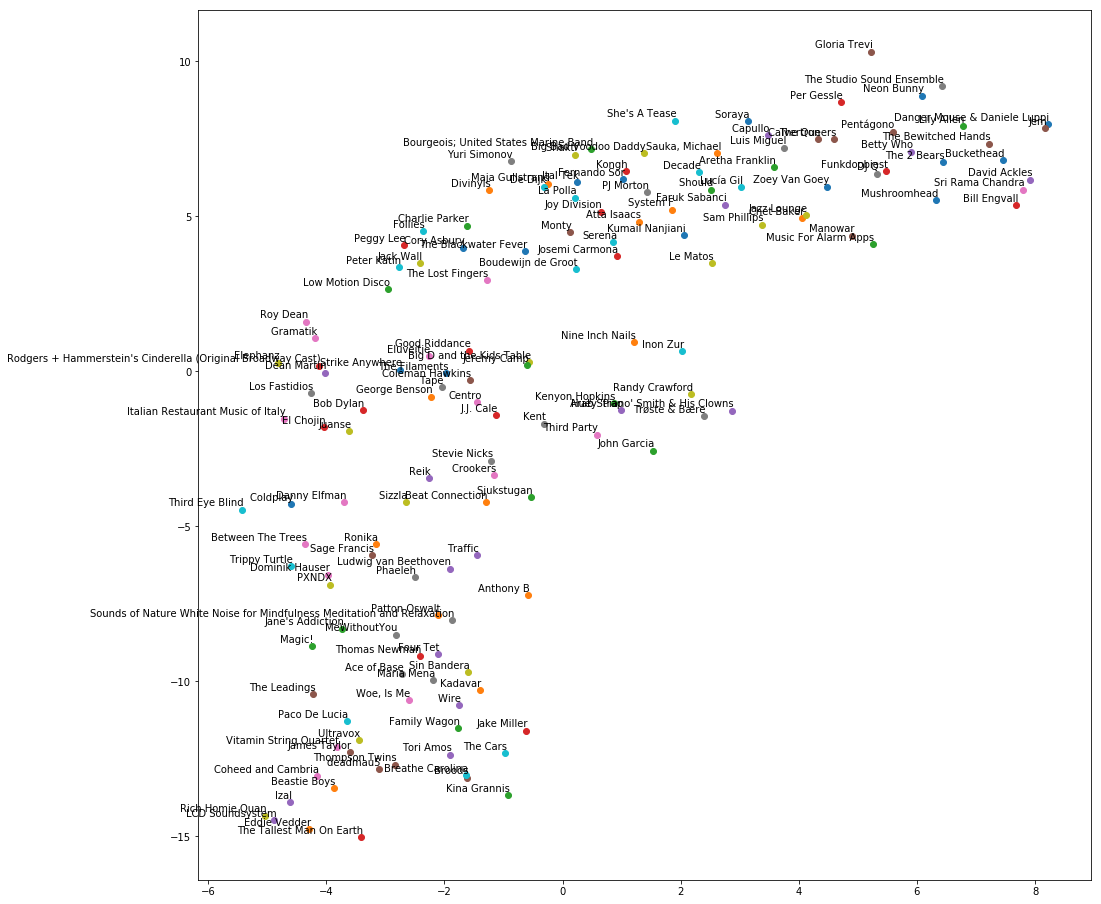

In [170]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        print("ge")
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 1),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

## Appendix

In [113]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)